# Skin disease recognition

Dermatology is one of the most neglected areas when it comes to preventing and maintaining human health. Many people do not pay attention to changes that occur on their skin, often treating them as something harmless that they have become accustomed to, putting a visit to a specialist at the bottom of their priority list. These growths, when left untreated, can remain dormant for a long time and then, for example, after exposure to an external factor, can take on a pathological form that significantly threatens our health.

In recent years, due to technological advances, modern computer tools have been increasingly used in the diagnosis of skin diseases. One of these tools is neural networks, which are excellent at detecting patterns in images for classification purposes. This allows for the early detection of potentially dangerous skin changes and faster medical intervention. The development of technology in image recognition enables the creation of increasingly advanced systems that can help diagnose skin diseases and improve the health of patients. This paper presents the process of recognizing skin changes based on photographs and evaluates the effectiveness of machine learning algorithms in this task.

Data comes from:
*Tschandl P., Rosendahl C. & Kittler H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018)*

<img src="img/dermatolog.jpg" alt="Dermatologist" width="700">

# Import libraries

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data gathering

### Dataset description
The dataset consists of following columns:
 - *lesion_id* - id number of particular lesion
 - *image_id* - image file name
 - *dx* - recognized lesion code, which stands for:
    - *akiec* - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
    - *bcc* - basal cell carcinoma
    - *bkl* - benign keratosis-like lesions
    - *df* - dermatofibroma
    - *mel* - melanoma
    - *nv* - melanocytic nevi
    - *vasc* - vascular lesions

 - *dx_type* - defines how was the lesion was recognized:
    - *histo* - through histopathology
    - *follow-up* - follow-up examination
    - *consensus* - expert consensus
    - *confocal* - confirmation by in-vivo confocal microscopy
 - *age* - patient's age group
 - *sex* - patient's sex
 - *localization* - localization of the lesion


### Loading images metadata
Read the file with recognized lesions data

In [2]:
lesions_df = pd.read_csv('archive/HAM10000_metadata.csv')
lesions_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Loading images
I will load the images using data generator object. A data generator is an object in TensorFlow that enables easy loading of large datasets, such as images, into memory one batch at a time. In the case of large datasets, such as image datasets, loading them all at once into memory can lead to the exhaustion of memory resources, as well as prolong the time it takes to load the data.

To properly connect labels from the dataframe with photos we need to pass correct filename, which mean we must modify the *image_id* column:

In [3]:
lesions_df['image_id'] = lesions_df['image_id'] + '.jpg'
lesions_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear


For proper training/validation data split I will shuffle the dataset, so that all classes are more-less evenly distributed in those subsets.

In [4]:
lesions_df = lesions_df.sample(frac=1)

# Exploratory data analysis
Let's have a look at how the diseases are distributed

### Lession types count
Let's check how many lesions of each category are in the dataset. I will split it into two charts, where one will show distribution of distinct lesions shown in the dataset and the other will show distribution of lesions images, because some lesions have couple photos. To do it I will prepare the second dataset for them.

In [4]:
distinct_lesions_df = lesions_df.drop('image_id', axis=1).drop_duplicates()
distinct_lesions_df.head()

,lesion_id,dx,dx_type,age,sex,localization
0,HAM_0000118,bkl,histo,80.0,male,scalp
2,HAM_0002730,bkl,histo,80.0,male,scalp
4,HAM_0001466,bkl,histo,75.0,male,ear
6,HAM_0002761,bkl,histo,60.0,male,face
8,HAM_0005132,bkl,histo,70.0,female,back


Next I will prepare a DataFrame to store both counted values

In [5]:
counts_df = pd.DataFrame()
counts_df['images_count'] = lesions_df['dx'].value_counts()
counts_df['lesions_count'] = distinct_lesions_df['dx'].value_counts()
counts_df

,images_count,lesions_count
nv,6705,5403
mel,1113,616
bkl,1099,727
bcc,514,327
akiec,327,228
vasc,142,98
df,115,73


...and create a plot

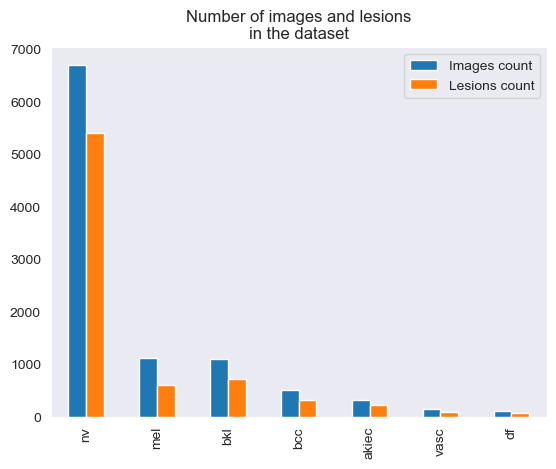

In [16]:
ax = counts_df.plot.bar()
ax.legend(labels=['Images count', 'Lesions count'])
ax.set_title('Number of images and lesions\nin the dataset')
ax.grid(False)
plt.show()

### Density plot for each lesion type vs age
Let's check how do the particular diseases appear in several age groups - this will be shown on density plot.

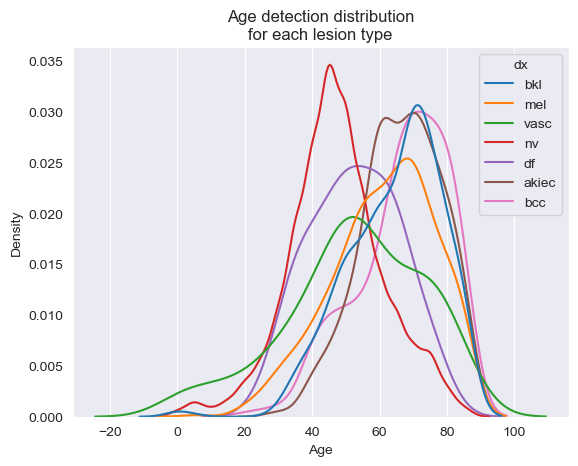

In [17]:
ax = sns.kdeplot(
    data=distinct_lesions_df,
    x='age',
    common_norm=False,
    hue='dx'
)
ax.set_title('Age detection distribution\nfor each lesion type')
ax.grid(axis='y', visible=False)
ax.set_xlabel('Age')

plt.show()

**Conclusion:** People at their forties should start to take care of melanocytic nevi disease (*nv*), while when reaching age of 50 dermatofibroma (*df*) and vascular lesions (*vasc*) most usually appear. The rest of diseases the most intensively appear after age of 60.

### Localization
Let's check the localization of each lesion. We will do it using a heatmap. We will start with creating a pivot table as an input data.

In [18]:
heatmap_table = distinct_lesions_df.pivot_table(index='dx', columns='localization', values='age', aggfunc='count').fillna(0)
heatmap_table

localization,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity
dx,,,,,,,,,,,,,,,
akiec,3.0,0.0,22.0,9.0,2.0,84.0,0.0,0.0,8.0,41.0,8.0,8.0,1.0,0.0,42.0
bcc,9.0,0.0,123.0,32.0,0.0,61.0,2.0,0.0,1.0,36.0,11.0,11.0,6.0,3.0,32.0
bkl,36.0,0.0,133.0,50.0,4.0,194.0,1.0,1.0,12.0,109.0,20.0,24.0,57.0,10.0,67.0
df,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,54.0,0.0,0.0,0.0,0.0,14.0
mel,31.0,0.0,185.0,34.0,10.0,64.0,15.0,0.0,1.0,104.0,18.0,9.0,27.0,6.0,111.0
nv,718.0,3.0,1058.0,111.0,19.0,61.0,208.0,43.0,39.0,1224.0,60.0,24.0,1152.0,138.0,503.0
vasc,22.0,0.0,12.0,3.0,0.0,5.0,0.0,0.0,3.0,16.0,2.0,2.0,27.0,0.0,6.0


Next I will normalize these values

In [19]:
heatmap_table_normalized = heatmap_table.copy()
for i in range(len(heatmap_table_normalized)):
    heatmap_table_normalized.iloc[i] = heatmap_table_normalized.iloc[i] / heatmap_table_normalized.iloc[i].sum() * 100
heatmap_table_normalized

localization,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity
dx,,,,,,,,,,,,,,,
akiec,1.315789,0.00000,9.649123,3.947368,0.877193,36.842105,0.000000,0.000000,3.508772,17.982456,3.508772,3.508772,0.438596,0.000000,18.421053
bcc,2.752294,0.00000,37.614679,9.785933,0.000000,18.654434,0.611621,0.000000,0.305810,11.009174,3.363914,3.363914,1.834862,0.917431,9.785933
bkl,5.013928,0.00000,18.523677,6.963788,0.557103,27.019499,0.139276,0.139276,1.671309,15.181058,2.785515,3.342618,7.938719,1.392758,9.331476
df,2.739726,0.00000,1.369863,0.000000,0.000000,0.000000,1.369863,1.369863,0.000000,73.972603,0.000000,0.000000,0.000000,0.000000,19.178082
mel,5.040650,0.00000,30.081301,5.528455,1.626016,10.406504,2.439024,0.000000,0.162602,16.910569,2.926829,1.463415,4.390244,0.975610,18.048780
nv,13.393024,0.05596,19.735124,2.070509,0.354411,1.137847,3.879873,0.802089,0.727476,22.831561,1.119194,0.447678,21.488528,2.574147,9.382578
vasc,22.448980,0.00000,12.244898,3.061224,0.000000,5.102041,0.000000,0.000000,3.061224,16.326531,2.040816,2.040816,27.551020,0.000000,6.122449


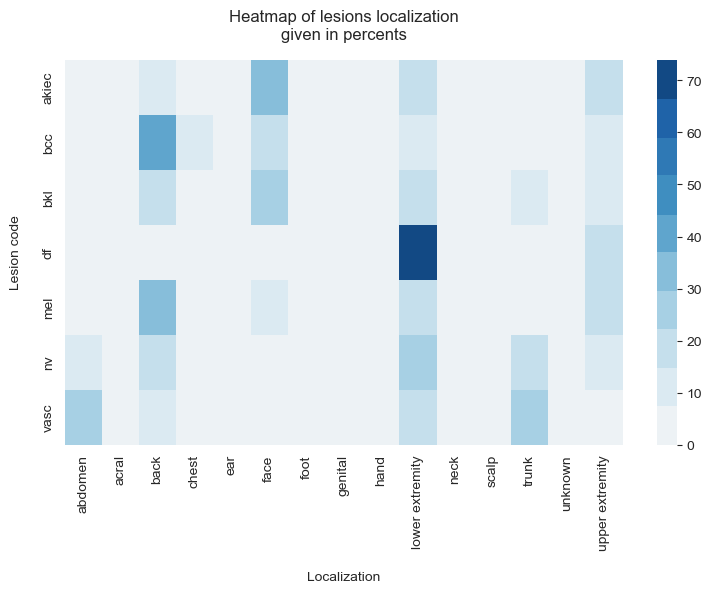

In [22]:
fig, ax = plt.subplots(figsize=(9,5), squeeze=False)

ax = sns.heatmap(
    data=heatmap_table_normalized,
    cmap=sns.color_palette('RdBu',20),
    ax=ax[0, 0],
    center=0
)
ax.set_ylabel('Lesion code', labelpad=15)
ax.set_xlabel('Localization', labelpad=15)
ax.set_title('Heatmap of lesions localization\ngiven in percents', pad=15)

plt.show()

**Conclusion:** Majority of lesions occur on lower extremity, back and face.

# Building model

First I will create an Image data generator - an object that will load the images to the model.

In [5]:
# Creating ImageDataGenerator object
img_generator = ImageDataGenerator(rescale=1. / 255)

### Splitting the data into training, validation and test sets

In [7]:
# First data split
lesions_train_df, lesions_test_df = train_test_split(lesions_df, test_size=0.1)
# Second split
lesions_train_df, lesions_valid_df = train_test_split(lesions_train_df, test_size=0.2)
print(f'Training data: {len(lesions_train_df)} elements')
print(f'Validation data: {len(lesions_valid_df)} elements')
print(f'Testing data: {len(lesions_test_df)} elements')

Training data: 7210 elements
Validation data: 1803 elements
Testing data: 1002 elements


### Outnumbered classes images augmentation
Optional TODO

Now I will create generators

In [8]:
# Images directory
img_dir = 'archive/HAM10000_images'
# Training data generator
train_generator = img_generator.flow_from_dataframe(dataframe=lesions_train_df,  # DataFrame with labels
                                                    directory=img_dir,  # images directory
                                                    x_col='image_id',  # column name containing images names
                                                    y_col='dx',  # column name containing labels
                                                    class_mode='categorical',  # classification mode
                                                    batch_size=32)
# Validation data generator
validation_generator = img_generator.flow_from_dataframe(dataframe=lesions_valid_df,
                                                         directory=img_dir,
                                                         x_col='image_id',
                                                         y_col='dx',
                                                         class_mode='categorical',
                                                         batch_size=32)
# Testing data generator
test_generator = img_generator.flow_from_dataframe(dataframe=lesions_test_df,
                                                    directory=img_dir,
                                                    x_col='image_id',
                                                    y_col='dx',
                                                    class_mode='categorical',
                                                    batch_size=32)

Found 7210 validated image filenames belonging to 7 classes.
Found 1803 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


### Check how the data has been split
We have to check if the data has been spit evenly into both - training and testing - sets.

In [11]:
# Counts values
index_train, counts_train = np.unique(train_generator.classes, return_counts=True)
index_valid, counts_valid = np.unique(validation_generator.classes, return_counts=True)
index_test, counts_test = np.unique(test_generator.classes, return_counts=True)
# Create DataFrame
split_counts_df = pd.DataFrame(index=train_generator.class_indices.keys())
split_counts_df['Training'] = counts_train
split_counts_df['Validation'] = counts_valid
split_counts_df['Testing'] = counts_test
# Show the DataFrame
split_counts_df

,Training,Validation,Testing
akiec,234,67,26
bcc,375,94,45
bkl,789,190,120
df,83,24,8
mel,775,222,116
nv,4853,1187,665
vasc,101,19,22


Now let's show it on the plot

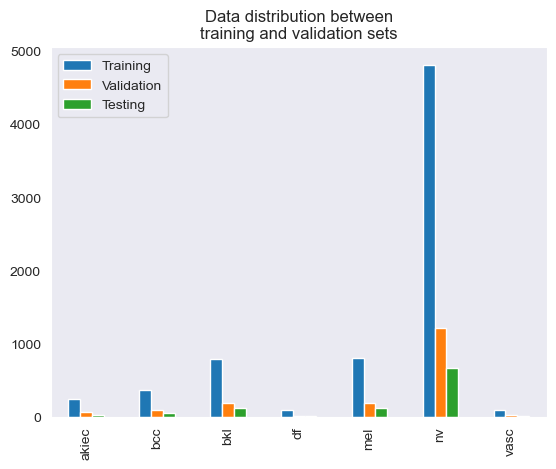

In [11]:
ax = split_counts_df.plot.bar()
ax.grid(False)
ax.set_title('Data distribution between\ntraining and validation sets')

plt.show()

**Conclusion:** The data has been split evenly, so in both datasets there will be similar samples distribution.

### Model architecture
Below the model architecture is defined. It uses a series of convolutional layers with increasing numbers of filters (32, 64, and 128), followed by max pooling layers to downsample the feature maps. The use of multiple convolutional layers allows the network to learn increasingly complex features from the images, while the max pooling layers reduce the spatial dimensions of the feature maps, allowing the network to focus on the most important features. The final dense layers use a softmax activation function to produce probability scores for each class. Additionally, the architecture includes a flatten layer that converts the 2D feature maps to a 1D feature vector, which is necessary for passing the features to the dense layers.

In [9]:
input_shape=(450, 600, 3)

In [278]:
model_1 = keras.Sequential([layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.GlobalAveragePooling2D(),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(7, activation='softmax')
])

In [279]:
model_2 = keras.Sequential([layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.GlobalAveragePooling2D(),
                            layers.Dropout(0.25),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(7, activation='softmax')
])

In [291]:
model_3 = keras.Sequential([layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(32, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.GlobalAveragePooling2D(),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(7, activation='softmax')
])

### Model class weights
As one class outnumbers others I will add weights to the classes to equalize their input to the loss function. This tells the algorithm to "pay more attention" to samples from an under-represented class.

In [20]:
# Get classes to predict during training
classes_train = train_generator.classes
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(classes_train), y=classes_train)
# Print it
class_weights_dict = dict(zip(range(7), class_weights))
for key in class_weights_dict:
    print(f'{key} -> {class_weights_dict[key]}')

0 -> 4.401709401709402
1 -> 2.7466666666666666
2 -> 1.3054499366286438
3 -> 12.409638554216867
4 -> 1.3290322580645162
5 -> 0.21223985163816197
6 -> 10.198019801980198


We can see that class with index 5, which outnumbers other classes has the lowest weight.

### Model class weights - manual version
Below I am setting manually classes weights, only to limit the impact of the most numerous class and to strengthen two the rarest ones.

In [15]:
class_weights_manual = dict()
for i in range(6):
    class_weights_manual[i] = 1

class_weights_manual[3] = 3
class_weights_manual[5] = 0.75
class_weights_manual[6] = 3

for key in class_weights_manual:
    print(f'{key} -> {class_weights_manual[key]}')

0 -> 1
1 -> 1
2 -> 1
3 -> 3
4 -> 1
5 -> 0.75
6 -> 3


### Model compilation
Model compilation is responsible for configuring it for training by specifying the optimizer, loss function, and metrics to be used during the training process. The optimizer determines how the model is updated based on the loss function and gradients calculated during training, while the loss function is used to measure the error between the predicted output and the actual output. Metrics are used to evaluate the performance of the model during training and can be used to monitor the progress of the training process.

optional TODO: choose parameters for non-even data distribution as 'accuracy' is good for evenly distributed classes

In [281]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [282]:
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [293]:
model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

### Training multiple models
In this stage I am training multiple models with various parameters to check which one will bring the best results for 10 epochs. This model will be trained on more epochs to get the best training.

In [35]:
models_dict = {'model_1': model_1, 'model_2': model_2, 'model_3': model_3}
weights_dict = {'None': None, 'computed': class_weights_dict, 'manual': class_weights_manual}

In [ ]:
# Create empty DF
model_results_columns = ['model', 'weights', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
models_results_df = pd.DataFrame(columns=model_results_columns)

# Iterate models
for multi_model in models_dict:
    # Iterate model classes weights
    for multi_weights in weights_dict:
        # Fit model
        history = models_dict[multi_model].fit(train_generator,
                                               epochs=10,
                                               validation_data=validation_generator,
                                               class_weight=weights_dict[multi_weights]
                                               )
        # Create DataFrame with results from this iteration
        models_results_iter = pd.DataFrame([[multi_model,
                                             multi_weights,
                                             history.history['loss'],
                                             history.history['accuracy'],
                                             history.history['val_loss'],
                                             history.history['val_accuracy'],
                                           ]],
                                           columns=model_results_columns
                                           )
        # Concatenate it with the main DataFrame
        models_results_df = pd.concat([models_results_df,
                                       models_results_iter
                                       ])

# Save results to .csv file
models_results_df.to_csv('test_results.csv', index=False)

In [40]:
models_results_df.head()

,model,weights,loss,accuracy,val_loss,val_accuracy
0,model_1,None,"[0.6700233817100525, 0.6330018043518066, 0.591...","[0.7481275796890259, 0.7595006823539734, 0.778...","[0.7870102524757385, 0.7809263467788696, 0.819...","[0.7054908275604248, 0.7104825377464294, 0.718..."
0,model_1,computed,"[1.1113598346710205, 0.7850975394248962, 0.672...","[0.6622745990753174, 0.6966713070869446, 0.739...","[1.2246404886245728, 1.4165431261062622, 1.404...","[0.6123127937316895, 0.5973377823829651, 0.638..."
0,model_1,manual,"[0.09706204384565353, 0.07332593202590942, 0.0...","[0.9596393704414368, 0.9718446731567383, 0.975...","[2.2071797847747803, 2.686591386795044, 2.6180...","[0.6866334080696106, 0.6927343606948853, 0.683..."
0,model_2,None,"[0.8856620192527771, 0.8417119383811951, 0.757...","[0.687656044960022, 0.6976421475410461, 0.7224...","[0.8704584836959839, 0.8063642382621765, 0.767...","[0.6727676391601562, 0.701608419418335, 0.7077..."
0,model_2,computed,"[1.192742943763733, 1.0348783731460571, 0.7072...","[0.611511766910553, 0.6396671533584595, 0.7238...","[2.34169602394104, 2.10721492767334, 1.9803913...","[0.4914032220840454, 0.5091513991355896, 0.439..."


Define a function to create performance plot of initial training

In [163]:
def plot_initial_results(parameter, title):

    fig_f, ax_f = plt.subplots(ncols=3, figsize=(18,5))
    fig_f.suptitle(title, fontsize=15)
    models_names_list = sorted(models_results_df['model'].unique())
    weights_names_list = sorted(models_results_df['weights'].unique())

    for model_number, model_name in enumerate(models_names_list):
        for weights_name in weights_names_list:
            for result in models_results_df.loc[(models_results_df['model']==model_name) &
                                                (models_results_df['weights']==weights_name),
                                                parameter
                                               ]:
                sns.lineplot(y=result,
                             x=range(1, len(result)+1),
                             ax=ax_f[model_number],
                             label=weights_name
                            )
                ax_f[model_number].set_xlabel('Epochs')
                ax_f[model_number].set_title(model_name)
                ax_f[model_number].legend()

    plt.show()

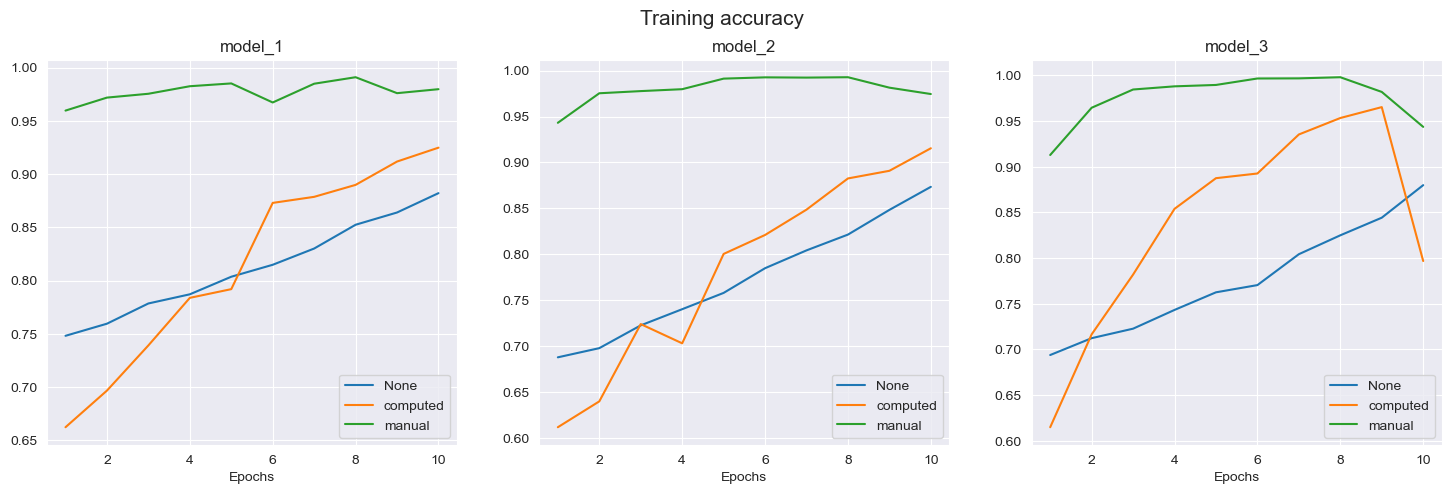

In [169]:
# Create accuracy plot
plot_initial_results('accuracy', 'Training accuracy')

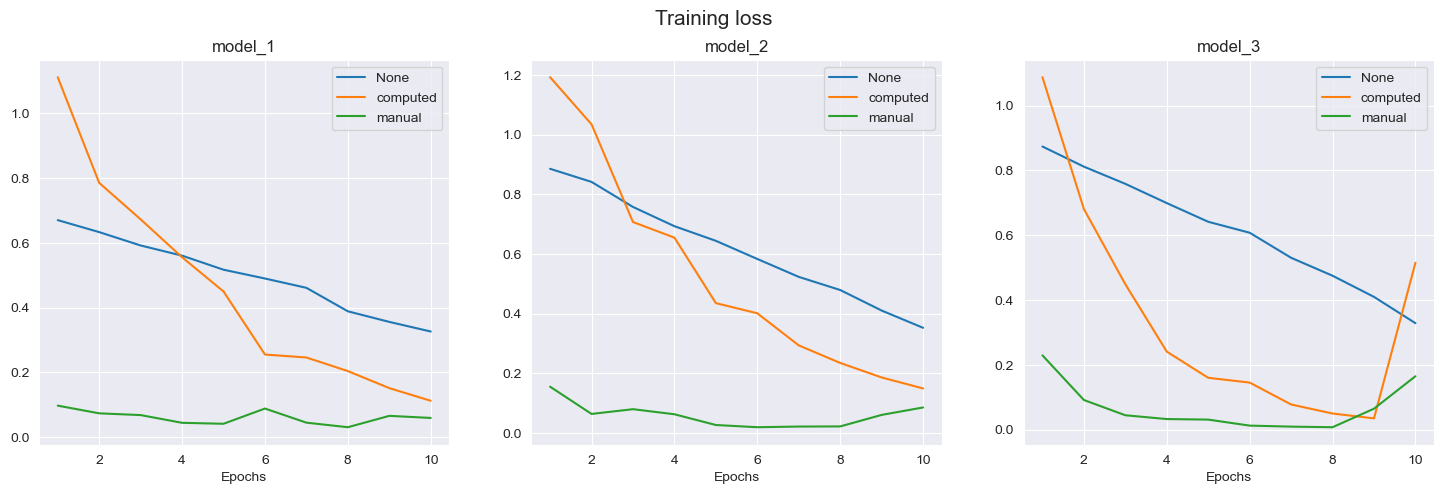

In [170]:
# Create loss plot
plot_initial_results('loss', 'Training loss')

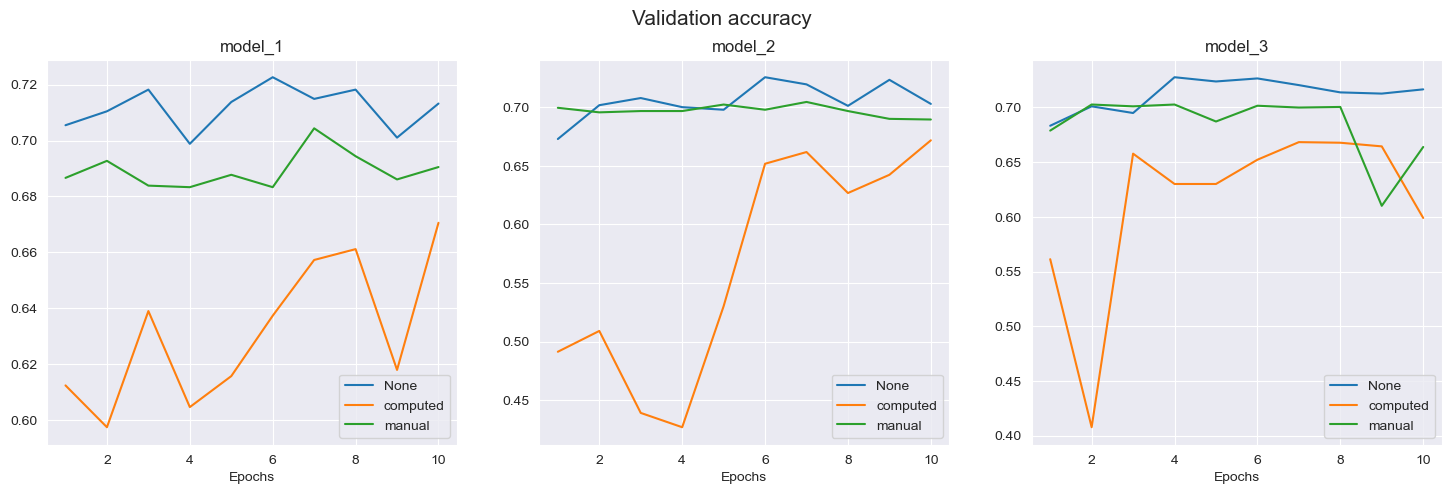

In [171]:
# Create validation accuracy plot
plot_initial_results('val_accuracy', 'Validation accuracy')

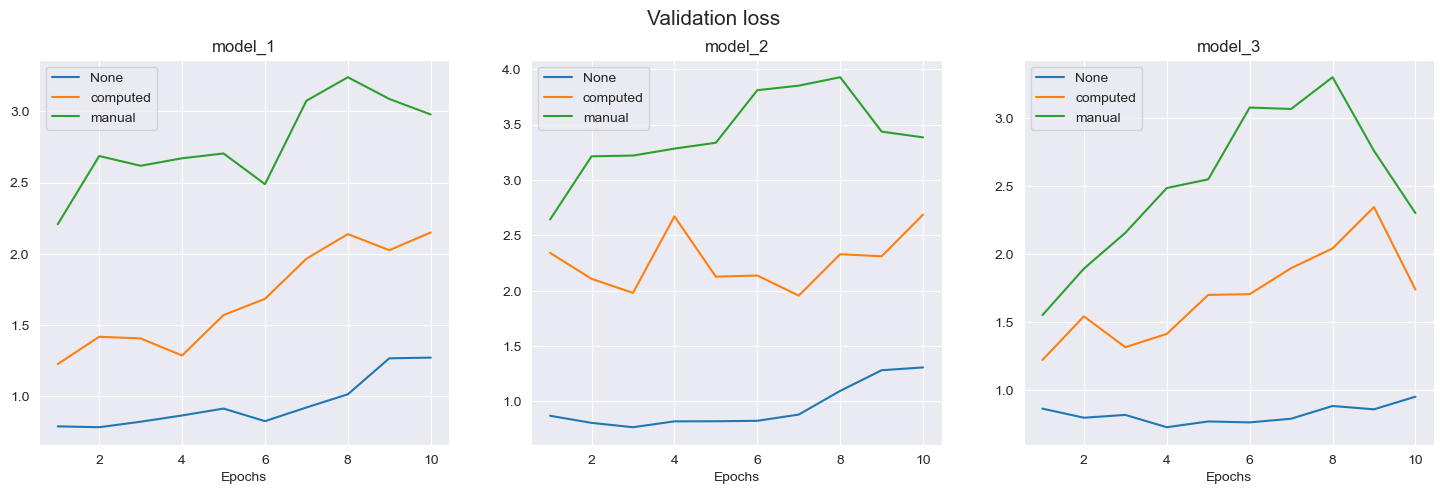

In [172]:
# Create validation loss plot
plot_initial_results('val_loss', 'Validation loss')

**Conclusion:** We can see the best performance of model XXX because

Best model architecture

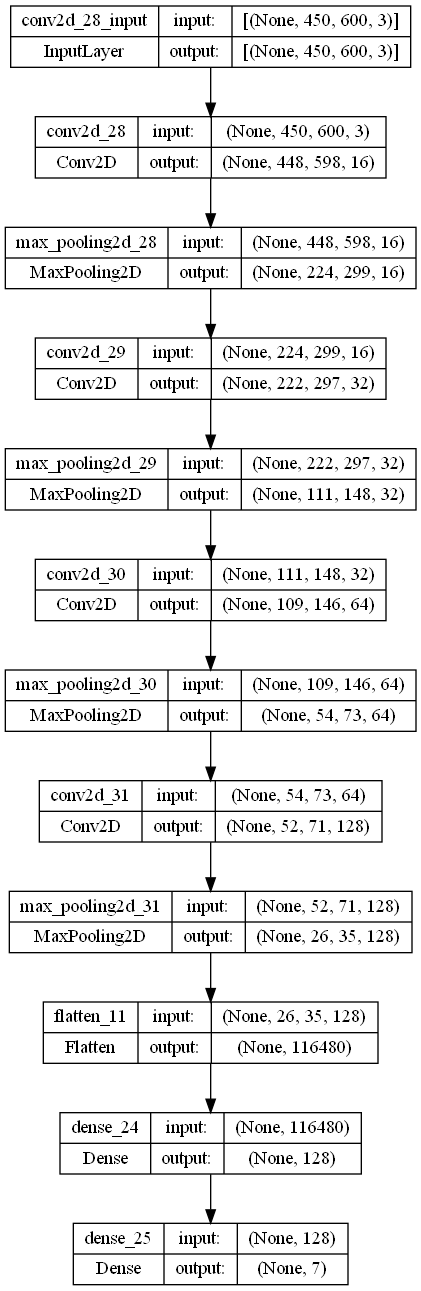

In [259]:
plot_model(model_3, show_shapes=True, show_layer_names=True)

### Training the model with more epochs
For further training I will take "XXXXX" model with XXXXX classes weights and 50 epochs. I will also define a callback to save model configuration with the best results.

In [256]:
callback_3 = keras.callbacks.ModelCheckpoint(filepath='model_3_callback.h5',
                                           monitor='val_acc',
                                           mode='max',
                                           verbose=1)

In [294]:
history_3 = model_3.fit(train_generator,
                        epochs=60,
                        validation_data=validation_generator,
                        class_weight=None,
                        callbacks=callback_3
)

Epoch 1/60
226/226 [==============================] - ETA: 0s - loss: 1.0899 - accuracy: 0.6703
Epoch 1: saving model to model_3_callback.h5
226/226 [==============================] - 230s 1s/step - loss: 1.0899 - accuracy: 0.6703 - val_loss: 1.0423 - val_accuracy: 0.6583
Epoch 2/60
226/226 [==============================] - ETA: 0s - loss: 1.0120 - accuracy: 0.6731
Epoch 2: saving model to model_3_callback.h5
226/226 [==============================] - 162s 718ms/step - loss: 1.0120 - accuracy: 0.6731 - val_loss: 1.0069 - val_accuracy: 0.6583
Epoch 3/60
226/226 [==============================] - ETA: 0s - loss: 0.9885 - accuracy: 0.6724
Epoch 3: saving model to model_3_callback.h5
226/226 [==============================] - 161s 712ms/step - loss: 0.9885 - accuracy: 0.6724 - val_loss: 0.9853 - val_accuracy: 0.6583
Epoch 4/60
226/226 [==============================] - ETA: 0s - loss: 0.9614 - accuracy: 0.6717
Epoch 4: saving model to model_3_callback.h5
226/226 [=========================

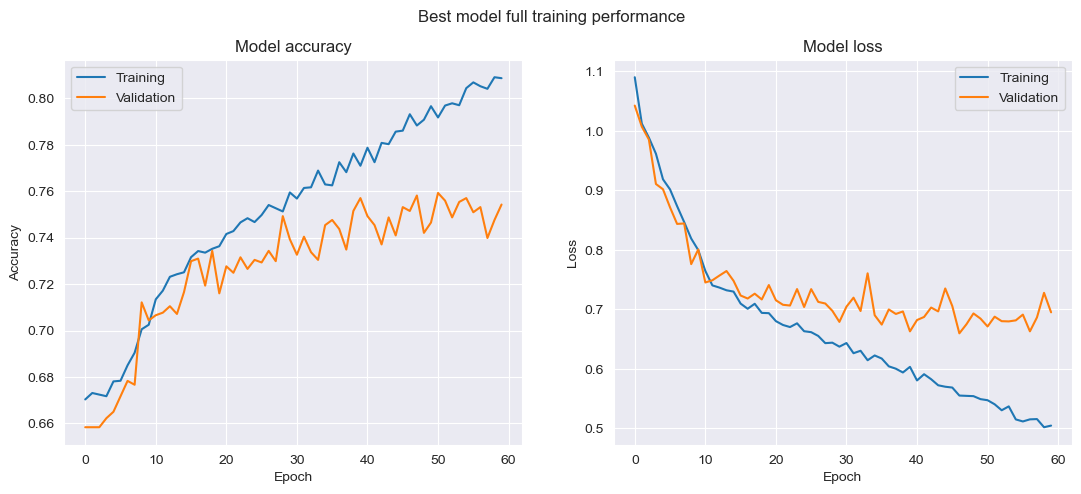

In [295]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))

ax[0].plot(history_3.history['accuracy'])
ax[0].plot(history_3.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'])

ax[1].plot(history_3.history['loss'])
ax[1].plot(history_3.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'])

plt.suptitle('Best model full training performance')
plt.show()

# Transfer learning
As the next step let's check how the model will work using transfer learning methods - I will use already pretrained network - MobileNet which will have the last couple of layers modified to fit it to our purposes. After that we will freeze first layers and train only the last ones responsible for final classification.

### Create a MobileNet model

In [19]:
mobilenet = keras.applications.mobilenet.MobileNet(include_top=False, input_shape=(224, 224, 3))

Let's check number of layers in this model

In [20]:
print(f'Number of layers in the MobileNet model: {len(mobilenet.layers)}')

Number of layers in the MobileNet model: 86


Model summary

In [21]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Modify the model
First I will cut the last 4 layers - so our model will include all the layers above *global_average_pooling2d* including it. Next I will add two last layers - dropout and classifying dense layer with 7 outputs.

In [27]:
# Create a new model
model_transfer = keras.models.Sequential()

# Add preprocessing layers to provide valid image size
model_transfer.add(layers.Resizing(height=224, width=299, input_shape=input_shape)) # resize
model_transfer.add(layers.CenterCrop(224, 224)) # crop

# Exclude last 4 layers from the original model
for layer in mobilenet.layers[:-3]:
    model_transfer.add(layer)

# Add final layers like in our previous models
model_transfer.add(layers.Flatten())
model_transfer.add(layers.Dense(128, activation='relu'))
model_transfer.add(layers.Dense(7, activation='softmax'))

model_transfer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 224, 299, 3)       0         
                                                                 
 center_crop_2 (CenterCrop)  (None, 224, 224, 3)       0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                      

Check number of layers after modification

In [28]:
print(f'Number of layers in the model_transfer model: {len(model_transfer.layers)}')

Number of layers in the model_transfer model: 88


We can see that number of layers changed. Now we can set trainable layers - we will use already trained layers and modify only last two convolutional layers and layers after them. That means we must freeze all but last 12 layers.

In [29]:
for layer in model_transfer.layers[:-13]:
    layer.trainable = False

### Train the model

Model compilation

In [30]:
model_transfer.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics='accuracy')

Define callback

In [32]:
callback_history = keras.callbacks.ModelCheckpoint(filepath='model_history_callback.h5',
                                                   monitor='val_acc',
                                                   mode='max',
                                                   verbose=1)

Fit the model

In [33]:
history_transfer = model_transfer.fit(train_generator,
                                      epochs=60,
                                      validation_data=validation_generator,
                                      callbacks=callback_history
                                      )

Epoch 1/60
226/226 [==============================] - ETA: 0s - loss: 2.0818 - accuracy: 0.6746
Epoch 1: saving model to model_history_callback.h5
226/226 [==============================] - 202s 892ms/step - loss: 2.0818 - accuracy: 0.6746 - val_loss: 3.9813 - val_accuracy: 0.6750
Epoch 2/60
226/226 [==============================] - ETA: 0s - loss: 1.4251 - accuracy: 0.7431
Epoch 2: saving model to model_history_callback.h5
226/226 [==============================] - 160s 708ms/step - loss: 1.4251 - accuracy: 0.7431 - val_loss: 5.8143 - val_accuracy: 0.7038
Epoch 3/60
226/226 [==============================] - ETA: 0s - loss: 0.9107 - accuracy: 0.7974
Epoch 3: saving model to model_history_callback.h5
226/226 [==============================] - 159s 702ms/step - loss: 0.9107 - accuracy: 0.7974 - val_loss: 3.0243 - val_accuracy: 0.7055
Epoch 4/60
226/226 [==============================] - ETA: 0s - loss: 0.8547 - accuracy: 0.8186
Epoch 4: saving model to model_history_callback.h5
226/226

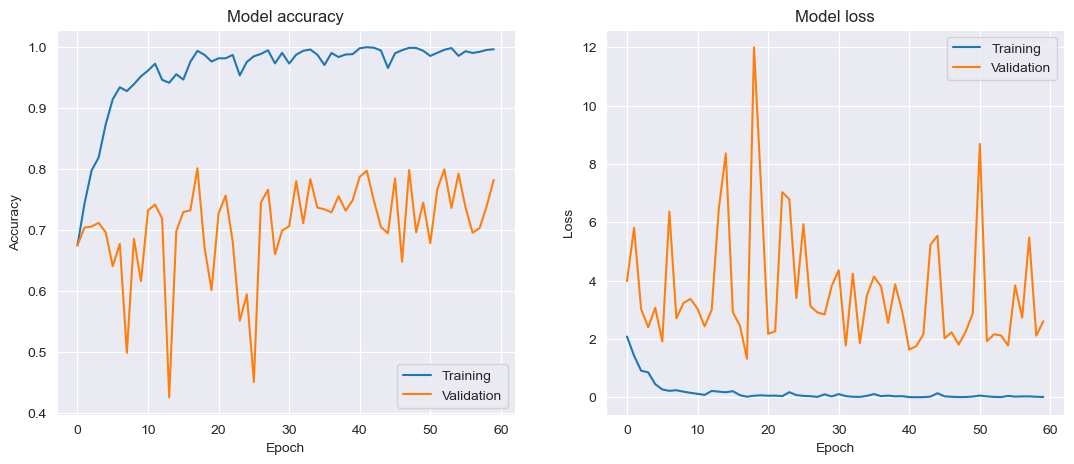

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))

ax[0].plot(history_transfer.history['accuracy'])
ax[0].plot(history_transfer.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'])

ax[1].plot(history_transfer.history['loss'])
ax[1].plot(history_transfer.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'])

plt.show()

### Other model training
I have also trained other promising model - *model_1* with computed weights, because it showed tendency to consistent learning in the initial stage. The results are shown below.

In [225]:
callback_1 = keras.callbacks.ModelCheckpoint(filepath='model_1_callback.h5',
                                             monitor='val_acc',
                                             mode='max',
                                             verbose=1)

In [226]:
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        validation_data=validation_generator,
                        class_weight=class_weights_dict,
                        callbacks=callback_1
                        )

Epoch 1/30
226/226 [==============================] - ETA: 0s - loss: 1.8355 - accuracy: 0.2545
Epoch 1: saving model to model_1_callback.h5
226/226 [==============================] - 290s 1s/step - loss: 1.8355 - accuracy: 0.2545 - val_loss: 1.9641 - val_accuracy: 0.0571
Epoch 2/30
226/226 [==============================] - ETA: 0s - loss: 1.6112 - accuracy: 0.3718
Epoch 2: saving model to model_1_callback.h5
226/226 [==============================] - 270s 1s/step - loss: 1.6112 - accuracy: 0.3718 - val_loss: 1.5200 - val_accuracy: 0.3971
Epoch 3/30
226/226 [==============================] - ETA: 0s - loss: 1.4861 - accuracy: 0.4441
Epoch 3: saving model to model_1_callback.h5
226/226 [==============================] - 293s 1s/step - loss: 1.4861 - accuracy: 0.4441 - val_loss: 2.1159 - val_accuracy: 0.0937
Epoch 4/30
226/226 [==============================] - ETA: 0s - loss: 1.4105 - accuracy: 0.4200
Epoch 4: saving model to model_1_callback.h5
226/226 [==============================]

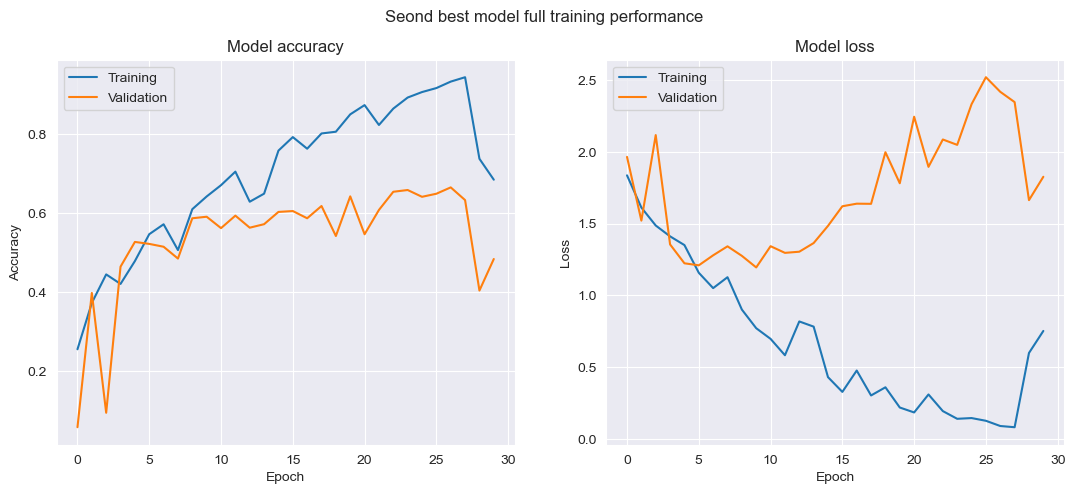

In [235]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))

ax[0].plot(history_1.history['accuracy'])
ax[0].plot(history_1.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'])

ax[1].plot(history_1.history['loss'])
ax[1].plot(history_1.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'])

plt.suptitle('Seond best model full training performance')
plt.show()

Nevermind, bad results

# Model evaluation
Let's compare both models on testing data

Load the best models using callback files

In [36]:
# Load model 3
model_3_best = load_model('model_3_callback.h5')
# Load model from transfer learning
model_transfer_best = load_model('model_history_callback.h5')

Evaluate model_3

In [41]:
model_3_best.evaluate(test_generator)

32/32 [==============================] - 9s 286ms/step - loss: 0.5417 - accuracy: 0.7904


[0.5416643023490906, 0.7904191613197327]

Evaluate transfer learning model

In [42]:
model_transfer_best.evaluate(test_generator)

32/32 [==============================] - 15s 441ms/step - loss: 2.7839 - accuracy: 0.7715


[2.783933162689209, 0.7714570760726929]

Predict values for both models

In [43]:
predicted_3 = model_3_best.predict(test_generator)
predicted_transfer = model_transfer_best.predict(test_generator)

32/32 [==============================] - 16s 474ms/step


### Confusion matrix
It shows outcome of real vs predicted values - we can see for which lesions the model works the worst.

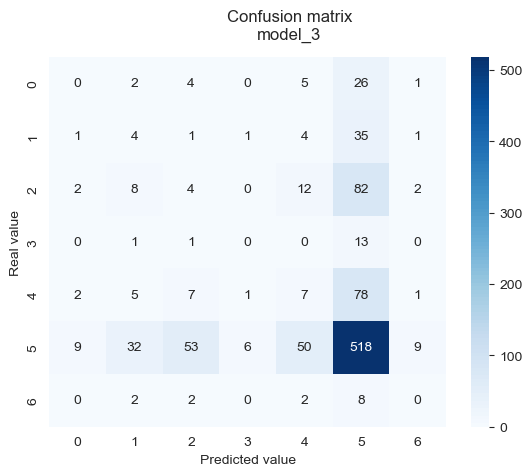

In [70]:
# Confusion matrix for model_3

predicted_values_3 = np.argmax(predicted_3, axis=1)
true_values = test_generator.classes
confusion_mtx_03 = confusion_matrix(true_values, predicted_values_3)

sns.heatmap(confusion_mtx_03,
            annot=True,
            fmt='d',
            cmap=(sns.color_palette('Blues', 100))
            )
plt.suptitle('Confusion matrix\nmodel_3')
plt.xlabel('Predicted value')
plt.ylabel('Real value')

plt.show()

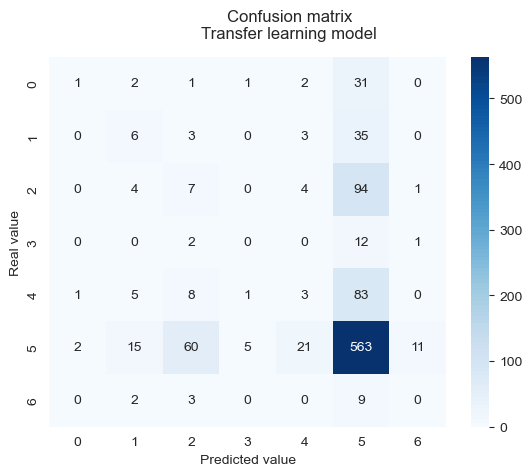

In [71]:
# Confusion matrix for transfer learning model

predicted_values_transfer = np.argmax(predicted_transfer, axis=1)
true_values = test_generator.classes
confusion_mtx_transfer = confusion_matrix(true_values, predicted_values_transfer)

sns.heatmap(confusion_mtx_transfer,
            annot=True,
            fmt='d',
            cmap=(sns.color_palette('Blues', 100))
            )
plt.suptitle('Confusion matrix\nTransfer learning model')
plt.xlabel('Predicted value')
plt.ylabel('Real value')

plt.show()

**Conclusion:** Both models show really strong overfitting tendency to the dominating class. Both of them have 3 classes, that have almost all wrong answers.

### Other metrics

In [77]:
model_3_results_compared = [true_values, predicted_values_3]

print('Model_3 test results:')
print('Precision:', precision_score(*model_3_results_compared, average='macro'))
print('Recall:', recall_score(*model_3_results_compared, average='macro'))
print('F1 score:', f1_score(*model_3_results_compared, average='macro'))

Model_3 test results:
Precision: 0.1283869395711501
Recall: 0.13655961071407163
F1 score: 0.13163692102731597


In [79]:
model_transfer_results_compared = [true_values, predicted_values_transfer]

print('Transer learning model test results:')
print('Precision:', precision_score(*model_transfer_results_compared, average='macro'))
print('Recall:', recall_score(*model_transfer_results_compared, average='macro'))
print('F1 score:', f1_score(*model_transfer_results_compared, average='macro'))

Transer learning model test results:
Precision: 0.18306955628244484
Recall: 0.15413210602690125
F1 score: 0.15162549662710667


### Conclusion
For the moment we have both models evaluated. Despite of theoretically high accuracy, almost 80 % for both of them, the results are far from satisfying, as 3 lesions are classified completely wrong. It is strongly recommended to deal with overfitting to the dominating class and my steps for the future are:
 - Check other metrics during initial and final training
 - Try to add some data augmentation for underrepresented classes
 - Play with architectures a bit, because it is suspicious that dropout layer brought decrease in results